In [1]:
import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset



In [2]:

# Define the image limit
BATCH_SIZE = 64
TRAIN_SIZE = 500 * BATCH_SIZE
TEST_SIZE = 10 * BATCH_SIZE
LOSS_EVERY = 1
EPOCHS = 1
SPLIT = 'train'
WEIGHT_DECAY=1e-3
LEARNING_RATE = .0001

device = os.environ["DEVICE"]
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224

class CachedImageNet(ImageNet):

    def __init__(self, root, split, version='0.1'):
        TRANSFORM = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        super().__init__(root=root, split=split, transform=TRANSFORM)
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]


    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        cache_path = self._get_cache_path(index)
        features = None
        if not os.path.exists(cache_path) or random() < .01:
            # Image transformations
            IMGNET_NORM = transforms.Compose([
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            imgnet_input = F.rgb_to_grayscale(IMGNET_NORM(img), num_output_channels=3).to(device).unsqueeze(0)

            def assign_features(module, input, output):
                nonlocal features
                features = output
            hook = self.resnet_layer.register_forward_hook(assign_features)
            
            with torch.no_grad():
                self.resnet50(imgnet_input)
            hook.remove()
            assert features is not None
            features = features.squeeze(0)
            if os.path.exists(cache_path):
                saved_features = torch.load(cache_path).to(device)
                assert torch.equal(features,saved_features)

            self.save_atomic(features, cache_path)
        else:
            features = torch.load(cache_path).to(device)

        target = F.rgb_to_grayscale(img, num_output_channels=1)
        return features, target
    def save_atomic(self, value, name):
        tmp_name = name + '.tmp' + str(random())
        torch.save(value, tmp_name)
        os.replace(tmp_name, name)
# Example feature extractor: compute mean/std per channel



# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split=SPLIT,
    version='0.9'
)


assert(len(train_dataset) >= TRAIN_SIZE + TEST_SIZE)

# Define the split sizes

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
test_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(train_dataset, test_subset_indices)

# Define the batch size

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Test loader contains {len(test_loader)} batches.")


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train loader contains 500 batches.
Test loader contains 10 batches.


torch.Size([64, 1, 224, 224])


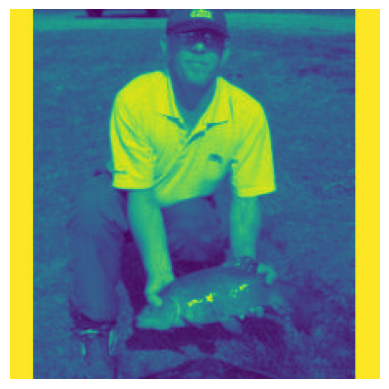

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
features, targets = next(data_iter)
print(targets.shape)
show_image(targets[0])  # Show the first image in the batch

In [4]:
class UpsampleModel(nn.Module):
    def __init__(self):
        super(UpsampleModel, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=768,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(768),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=768, out_channels=512,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=512, out_channels=384,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=384, out_channels=256,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(256, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(32, 16, kernel_size=1, padding=0),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, kernel_size=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)



# Example usage:
model = UpsampleModel()


input_tensor = torch.randn(1, 1024, 14, 14)  # Batch size = 1
output_tensor = model(input_tensor)
assert output_tensor.shape == torch.Size([1,1,224,224])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total parametrs: ", count_parameters(model))


Total parametrs:  24511329


In [5]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

T_max = len(train_loader) * EPOCHS  # Total number of batches across all epochs

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

In [6]:
import torch


# Training loop
model.train()
model.to(device)
running_loss = 0.0
losses = []
for epoch in range(EPOCHS):
    for i, (features, target) in enumerate(train_loader):
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the scheduler after each batch
        scheduler.step()

        # Log the running loss
        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY - 1:
            avg_loss = running_loss / LOSS_EVERY
            print(f"Epoch {epoch+1}, Batch {i+1}, LR: {scheduler.get_last_lr()[0]:.6f}, Loss: {avg_loss:.4f}")
            losses.append(avg_loss)
            running_loss = 0.0


Epoch 1, Batch 1, LR: 0.000100, Loss: 0.8800


Epoch 1, Batch 2, LR: 0.000100, Loss: 0.9095


Epoch 1, Batch 3, LR: 0.000100, Loss: 0.7349


Epoch 1, Batch 4, LR: 0.000100, Loss: 0.7010


Epoch 1, Batch 5, LR: 0.000100, Loss: 0.6717


Epoch 1, Batch 6, LR: 0.000100, Loss: 0.6541


Epoch 1, Batch 7, LR: 0.000100, Loss: 0.6362


Epoch 1, Batch 8, LR: 0.000100, Loss: 0.6173


Epoch 1, Batch 9, LR: 0.000100, Loss: 0.6179


Epoch 1, Batch 10, LR: 0.000100, Loss: 0.5953


Epoch 1, Batch 11, LR: 0.000100, Loss: 0.6080


Epoch 1, Batch 12, LR: 0.000100, Loss: 0.6107


Epoch 1, Batch 13, LR: 0.000100, Loss: 0.5996


Epoch 1, Batch 14, LR: 0.000100, Loss: 0.5760


Epoch 1, Batch 15, LR: 0.000100, Loss: 0.5943


Epoch 1, Batch 16, LR: 0.000100, Loss: 0.5869


Epoch 1, Batch 17, LR: 0.000100, Loss: 0.5755


Epoch 1, Batch 18, LR: 0.000100, Loss: 0.5904


Epoch 1, Batch 19, LR: 0.000100, Loss: 0.5718


Epoch 1, Batch 20, LR: 0.000100, Loss: 0.5708


Epoch 1, Batch 21, LR: 0.000100, Loss: 0.5793


Epoch 1, Batch 22, LR: 0.000100, Loss: 0.5958


Epoch 1, Batch 23, LR: 0.000099, Loss: 0.5972


Epoch 1, Batch 24, LR: 0.000099, Loss: 0.6118


Epoch 1, Batch 25, LR: 0.000099, Loss: 0.5946


Epoch 1, Batch 26, LR: 0.000099, Loss: 0.5932


Epoch 1, Batch 27, LR: 0.000099, Loss: 0.5870


Epoch 1, Batch 28, LR: 0.000099, Loss: 0.5987


Epoch 1, Batch 29, LR: 0.000099, Loss: 0.5922


Epoch 1, Batch 30, LR: 0.000099, Loss: 0.5916


Epoch 1, Batch 31, LR: 0.000099, Loss: 0.5564


Epoch 1, Batch 32, LR: 0.000099, Loss: 0.5763


Epoch 1, Batch 33, LR: 0.000099, Loss: 0.5882


Epoch 1, Batch 34, LR: 0.000099, Loss: 0.5927


Epoch 1, Batch 35, LR: 0.000099, Loss: 0.5171


Epoch 1, Batch 36, LR: 0.000099, Loss: 0.5385


Epoch 1, Batch 37, LR: 0.000099, Loss: 0.5458


Epoch 1, Batch 38, LR: 0.000099, Loss: 0.5735


Epoch 1, Batch 39, LR: 0.000099, Loss: 0.6120


Epoch 1, Batch 40, LR: 0.000098, Loss: 0.5737


Epoch 1, Batch 41, LR: 0.000098, Loss: 0.6141


Epoch 1, Batch 42, LR: 0.000098, Loss: 0.5953


Epoch 1, Batch 43, LR: 0.000098, Loss: 0.6083


Epoch 1, Batch 44, LR: 0.000098, Loss: 0.5939


Epoch 1, Batch 45, LR: 0.000098, Loss: 0.6135


Epoch 1, Batch 46, LR: 0.000098, Loss: 0.6094


Epoch 1, Batch 47, LR: 0.000098, Loss: 0.6007


Epoch 1, Batch 48, LR: 0.000098, Loss: 0.6022


Epoch 1, Batch 49, LR: 0.000098, Loss: 0.6057


Epoch 1, Batch 50, LR: 0.000098, Loss: 0.5946


Epoch 1, Batch 51, LR: 0.000097, Loss: 0.5998


Epoch 1, Batch 52, LR: 0.000097, Loss: 0.5988


Epoch 1, Batch 53, LR: 0.000097, Loss: 0.5846


Epoch 1, Batch 54, LR: 0.000097, Loss: 0.5977


Epoch 1, Batch 55, LR: 0.000097, Loss: 0.6061


Epoch 1, Batch 56, LR: 0.000097, Loss: 0.6065


Epoch 1, Batch 57, LR: 0.000097, Loss: 0.5979


Epoch 1, Batch 58, LR: 0.000097, Loss: 0.6108


Epoch 1, Batch 59, LR: 0.000097, Loss: 0.6068


Epoch 1, Batch 60, LR: 0.000096, Loss: 0.6034


Epoch 1, Batch 61, LR: 0.000096, Loss: 0.6059


Epoch 1, Batch 62, LR: 0.000096, Loss: 0.5855


Epoch 1, Batch 63, LR: 0.000096, Loss: 0.5844


Epoch 1, Batch 64, LR: 0.000096, Loss: 0.5791


Epoch 1, Batch 65, LR: 0.000096, Loss: 0.6053


Epoch 1, Batch 66, LR: 0.000096, Loss: 0.5993


Epoch 1, Batch 67, LR: 0.000096, Loss: 0.5956


Epoch 1, Batch 68, LR: 0.000096, Loss: 0.5866


Epoch 1, Batch 69, LR: 0.000095, Loss: 0.5905


Epoch 1, Batch 70, LR: 0.000095, Loss: 0.6046


Epoch 1, Batch 71, LR: 0.000095, Loss: 0.5909


Epoch 1, Batch 72, LR: 0.000095, Loss: 0.5761


Epoch 1, Batch 73, LR: 0.000095, Loss: 0.5831


Epoch 1, Batch 74, LR: 0.000095, Loss: 0.5914


Epoch 1, Batch 75, LR: 0.000095, Loss: 0.6077


Epoch 1, Batch 76, LR: 0.000094, Loss: 0.5963


Epoch 1, Batch 77, LR: 0.000094, Loss: 0.5892


Epoch 1, Batch 78, LR: 0.000094, Loss: 0.5959


Epoch 1, Batch 79, LR: 0.000094, Loss: 0.5963


Epoch 1, Batch 80, LR: 0.000094, Loss: 0.5814


Epoch 1, Batch 81, LR: 0.000094, Loss: 0.5950


Epoch 1, Batch 82, LR: 0.000094, Loss: 0.5865


Epoch 1, Batch 83, LR: 0.000093, Loss: 0.5810


Epoch 1, Batch 84, LR: 0.000093, Loss: 0.5918


Epoch 1, Batch 85, LR: 0.000093, Loss: 0.5783


Epoch 1, Batch 86, LR: 0.000093, Loss: 0.5834


Epoch 1, Batch 87, LR: 0.000093, Loss: 0.5916


Epoch 1, Batch 88, LR: 0.000093, Loss: 0.5780


Epoch 1, Batch 89, LR: 0.000092, Loss: 0.5653


Epoch 1, Batch 90, LR: 0.000092, Loss: 0.5595


Epoch 1, Batch 91, LR: 0.000092, Loss: 0.5598


Epoch 1, Batch 92, LR: 0.000092, Loss: 0.5772


Epoch 1, Batch 93, LR: 0.000092, Loss: 0.5785


Epoch 1, Batch 94, LR: 0.000092, Loss: 0.5700


Epoch 1, Batch 95, LR: 0.000091, Loss: 0.5857


Epoch 1, Batch 96, LR: 0.000091, Loss: 0.5868


Epoch 1, Batch 97, LR: 0.000091, Loss: 0.5814


Epoch 1, Batch 98, LR: 0.000091, Loss: 0.5750


Epoch 1, Batch 99, LR: 0.000091, Loss: 0.5644


Epoch 1, Batch 100, LR: 0.000090, Loss: 0.5851


Epoch 1, Batch 101, LR: 0.000090, Loss: 0.5881


Epoch 1, Batch 102, LR: 0.000090, Loss: 0.5749


Epoch 1, Batch 103, LR: 0.000090, Loss: 0.5466


Epoch 1, Batch 104, LR: 0.000090, Loss: 0.5392


Epoch 1, Batch 105, LR: 0.000090, Loss: 0.5606


Epoch 1, Batch 106, LR: 0.000089, Loss: 0.5694


Epoch 1, Batch 107, LR: 0.000089, Loss: 0.6023


Epoch 1, Batch 108, LR: 0.000089, Loss: 0.5979


Epoch 1, Batch 109, LR: 0.000089, Loss: 0.5919


Epoch 1, Batch 110, LR: 0.000089, Loss: 0.5946


Epoch 1, Batch 111, LR: 0.000088, Loss: 0.5213


Epoch 1, Batch 112, LR: 0.000088, Loss: 0.5481


Epoch 1, Batch 113, LR: 0.000088, Loss: 0.5449


Epoch 1, Batch 114, LR: 0.000088, Loss: 0.5764


Epoch 1, Batch 115, LR: 0.000088, Loss: 0.5239


Epoch 1, Batch 116, LR: 0.000087, Loss: 0.5611


Epoch 1, Batch 117, LR: 0.000087, Loss: 0.5598


Epoch 1, Batch 118, LR: 0.000087, Loss: 0.5471


Epoch 1, Batch 119, LR: 0.000087, Loss: 0.5138


Epoch 1, Batch 120, LR: 0.000086, Loss: 0.5717


Epoch 1, Batch 121, LR: 0.000086, Loss: 0.5464


Epoch 1, Batch 122, LR: 0.000086, Loss: 0.5573


Epoch 1, Batch 123, LR: 0.000086, Loss: 0.6442


Epoch 1, Batch 124, LR: 0.000086, Loss: 0.6188


Epoch 1, Batch 125, LR: 0.000085, Loss: 0.6191


Epoch 1, Batch 126, LR: 0.000085, Loss: 0.6232


Epoch 1, Batch 127, LR: 0.000085, Loss: 0.6198


Epoch 1, Batch 128, LR: 0.000085, Loss: 0.6200


Epoch 1, Batch 129, LR: 0.000084, Loss: 0.6393


Epoch 1, Batch 130, LR: 0.000084, Loss: 0.6172


Epoch 1, Batch 131, LR: 0.000084, Loss: 0.6188


Epoch 1, Batch 132, LR: 0.000084, Loss: 0.6068


Epoch 1, Batch 133, LR: 0.000084, Loss: 0.6248


Epoch 1, Batch 134, LR: 0.000083, Loss: 0.6088


Epoch 1, Batch 135, LR: 0.000083, Loss: 0.6111


Epoch 1, Batch 136, LR: 0.000083, Loss: 0.6192


Epoch 1, Batch 137, LR: 0.000083, Loss: 0.6208


Epoch 1, Batch 138, LR: 0.000082, Loss: 0.6216


Epoch 1, Batch 139, LR: 0.000082, Loss: 0.6189


Epoch 1, Batch 140, LR: 0.000082, Loss: 0.6212


Epoch 1, Batch 141, LR: 0.000082, Loss: 0.6183


Epoch 1, Batch 142, LR: 0.000081, Loss: 0.5852


Epoch 1, Batch 143, LR: 0.000081, Loss: 0.5870


Epoch 1, Batch 144, LR: 0.000081, Loss: 0.5806


Epoch 1, Batch 145, LR: 0.000081, Loss: 0.5598


Epoch 1, Batch 146, LR: 0.000080, Loss: 0.5745


Epoch 1, Batch 147, LR: 0.000080, Loss: 0.5698


Epoch 1, Batch 148, LR: 0.000080, Loss: 0.5777


Epoch 1, Batch 149, LR: 0.000080, Loss: 0.5698


Epoch 1, Batch 150, LR: 0.000079, Loss: 0.5633


Epoch 1, Batch 151, LR: 0.000079, Loss: 0.5598


Epoch 1, Batch 152, LR: 0.000079, Loss: 0.5627


Epoch 1, Batch 153, LR: 0.000079, Loss: 0.5598


Epoch 1, Batch 154, LR: 0.000078, Loss: 0.5578


Epoch 1, Batch 155, LR: 0.000078, Loss: 0.5641


Epoch 1, Batch 156, LR: 0.000078, Loss: 0.5625


Epoch 1, Batch 157, LR: 0.000078, Loss: 0.5712


Epoch 1, Batch 158, LR: 0.000077, Loss: 0.5597


Epoch 1, Batch 159, LR: 0.000077, Loss: 0.5551


Epoch 1, Batch 160, LR: 0.000077, Loss: 0.5635


Epoch 1, Batch 161, LR: 0.000077, Loss: 0.5560


Epoch 1, Batch 162, LR: 0.000076, Loss: 0.5588


Epoch 1, Batch 163, LR: 0.000076, Loss: 0.5687


Epoch 1, Batch 164, LR: 0.000076, Loss: 0.5673


Epoch 1, Batch 165, LR: 0.000075, Loss: 0.5539


Epoch 1, Batch 166, LR: 0.000075, Loss: 0.5683


Epoch 1, Batch 167, LR: 0.000075, Loss: 0.5670


Epoch 1, Batch 168, LR: 0.000075, Loss: 0.5680


Epoch 1, Batch 169, LR: 0.000074, Loss: 0.5727


Epoch 1, Batch 170, LR: 0.000074, Loss: 0.5743


Epoch 1, Batch 171, LR: 0.000074, Loss: 0.5884


Epoch 1, Batch 172, LR: 0.000074, Loss: 0.5761


Epoch 1, Batch 173, LR: 0.000073, Loss: 0.5908


Epoch 1, Batch 174, LR: 0.000073, Loss: 0.5797


Epoch 1, Batch 175, LR: 0.000073, Loss: 0.5712


Epoch 1, Batch 176, LR: 0.000072, Loss: 0.5682


Epoch 1, Batch 177, LR: 0.000072, Loss: 0.5789


Epoch 1, Batch 178, LR: 0.000072, Loss: 0.5738


Epoch 1, Batch 179, LR: 0.000072, Loss: 0.5739


Epoch 1, Batch 180, LR: 0.000071, Loss: 0.5544


Epoch 1, Batch 181, LR: 0.000071, Loss: 0.5758


Epoch 1, Batch 182, LR: 0.000071, Loss: 0.5801


Epoch 1, Batch 183, LR: 0.000070, Loss: 0.5757


Epoch 1, Batch 184, LR: 0.000070, Loss: 0.5784


Epoch 1, Batch 185, LR: 0.000070, Loss: 0.5829


Epoch 1, Batch 186, LR: 0.000070, Loss: 0.5671


Epoch 1, Batch 187, LR: 0.000069, Loss: 0.5759


Epoch 1, Batch 188, LR: 0.000069, Loss: 0.5720


Epoch 1, Batch 189, LR: 0.000069, Loss: 0.5625


Epoch 1, Batch 190, LR: 0.000068, Loss: 0.5839


Epoch 1, Batch 191, LR: 0.000068, Loss: 0.5784


Epoch 1, Batch 192, LR: 0.000068, Loss: 0.5910


Epoch 1, Batch 193, LR: 0.000068, Loss: 0.5703


Epoch 1, Batch 194, LR: 0.000067, Loss: 0.5846


Epoch 1, Batch 195, LR: 0.000067, Loss: 0.5716


Epoch 1, Batch 196, LR: 0.000067, Loss: 0.5939


Epoch 1, Batch 197, LR: 0.000066, Loss: 0.5849


Epoch 1, Batch 198, LR: 0.000066, Loss: 0.5719


Epoch 1, Batch 199, LR: 0.000066, Loss: 0.5684


Epoch 1, Batch 200, LR: 0.000065, Loss: 0.5817


Epoch 1, Batch 201, LR: 0.000065, Loss: 0.5677


Epoch 1, Batch 202, LR: 0.000065, Loss: 0.5462


Epoch 1, Batch 203, LR: 0.000065, Loss: 0.5751


Epoch 1, Batch 204, LR: 0.000064, Loss: 0.5923


Epoch 1, Batch 205, LR: 0.000064, Loss: 0.6066


Epoch 1, Batch 206, LR: 0.000064, Loss: 0.6065


Epoch 1, Batch 207, LR: 0.000063, Loss: 0.5990


Epoch 1, Batch 208, LR: 0.000063, Loss: 0.5829


Epoch 1, Batch 209, LR: 0.000063, Loss: 0.5712


Epoch 1, Batch 210, LR: 0.000062, Loss: 0.5690


Epoch 1, Batch 211, LR: 0.000062, Loss: 0.5689


Epoch 1, Batch 212, LR: 0.000062, Loss: 0.5400


Epoch 1, Batch 213, LR: 0.000062, Loss: 0.5740


Epoch 1, Batch 214, LR: 0.000061, Loss: 0.5633


Epoch 1, Batch 215, LR: 0.000061, Loss: 0.5581


Epoch 1, Batch 216, LR: 0.000061, Loss: 0.5733


Epoch 1, Batch 217, LR: 0.000060, Loss: 0.5731


Epoch 1, Batch 218, LR: 0.000060, Loss: 0.5675


Epoch 1, Batch 219, LR: 0.000060, Loss: 0.5569


Epoch 1, Batch 220, LR: 0.000059, Loss: 0.5525


Epoch 1, Batch 221, LR: 0.000059, Loss: 0.5546


Epoch 1, Batch 222, LR: 0.000059, Loss: 0.5526


Epoch 1, Batch 223, LR: 0.000058, Loss: 0.5551


Epoch 1, Batch 224, LR: 0.000058, Loss: 0.5756


Epoch 1, Batch 225, LR: 0.000058, Loss: 0.5686


Epoch 1, Batch 226, LR: 0.000058, Loss: 0.5888


Epoch 1, Batch 227, LR: 0.000057, Loss: 0.5980


Epoch 1, Batch 228, LR: 0.000057, Loss: 0.5778


Epoch 1, Batch 229, LR: 0.000057, Loss: 0.5974


Epoch 1, Batch 230, LR: 0.000056, Loss: 0.5966


Epoch 1, Batch 231, LR: 0.000056, Loss: 0.6044


Epoch 1, Batch 232, LR: 0.000056, Loss: 0.5835


Epoch 1, Batch 233, LR: 0.000055, Loss: 0.6023


Epoch 1, Batch 234, LR: 0.000055, Loss: 0.6012


Epoch 1, Batch 235, LR: 0.000055, Loss: 0.5949


Epoch 1, Batch 236, LR: 0.000054, Loss: 0.5825


Epoch 1, Batch 237, LR: 0.000054, Loss: 0.5881


Epoch 1, Batch 238, LR: 0.000054, Loss: 0.5998


Epoch 1, Batch 239, LR: 0.000053, Loss: 0.5905


Epoch 1, Batch 240, LR: 0.000053, Loss: 0.5916


Epoch 1, Batch 241, LR: 0.000053, Loss: 0.5944


Epoch 1, Batch 242, LR: 0.000053, Loss: 0.5738


Epoch 1, Batch 243, LR: 0.000052, Loss: 0.5910


Epoch 1, Batch 244, LR: 0.000052, Loss: 0.5893


Epoch 1, Batch 245, LR: 0.000052, Loss: 0.6001


Epoch 1, Batch 246, LR: 0.000051, Loss: 0.5913


Epoch 1, Batch 247, LR: 0.000051, Loss: 0.6034


Epoch 1, Batch 248, LR: 0.000051, Loss: 0.5943


Epoch 1, Batch 249, LR: 0.000050, Loss: 0.6028


Epoch 1, Batch 250, LR: 0.000050, Loss: 0.5917


Epoch 1, Batch 251, LR: 0.000050, Loss: 0.6093


Epoch 1, Batch 252, LR: 0.000049, Loss: 0.6032


Epoch 1, Batch 253, LR: 0.000049, Loss: 0.6097


Epoch 1, Batch 254, LR: 0.000049, Loss: 0.6000


Epoch 1, Batch 255, LR: 0.000048, Loss: 0.5920


Epoch 1, Batch 256, LR: 0.000048, Loss: 0.5812


Epoch 1, Batch 257, LR: 0.000048, Loss: 0.6044


Epoch 1, Batch 258, LR: 0.000047, Loss: 0.6000


Epoch 1, Batch 259, LR: 0.000047, Loss: 0.5991


Epoch 1, Batch 260, LR: 0.000047, Loss: 0.5926


Epoch 1, Batch 261, LR: 0.000047, Loss: 0.5861


Epoch 1, Batch 262, LR: 0.000046, Loss: 0.6068


Epoch 1, Batch 263, LR: 0.000046, Loss: 0.5901


Epoch 1, Batch 264, LR: 0.000046, Loss: 0.5964


Epoch 1, Batch 265, LR: 0.000045, Loss: 0.6030


Epoch 1, Batch 266, LR: 0.000045, Loss: 0.5703


Epoch 1, Batch 267, LR: 0.000045, Loss: 0.5902


Epoch 1, Batch 268, LR: 0.000044, Loss: 0.5826


Epoch 1, Batch 269, LR: 0.000044, Loss: 0.5759


Epoch 1, Batch 270, LR: 0.000044, Loss: 0.5917


Epoch 1, Batch 271, LR: 0.000043, Loss: 0.5979


Epoch 1, Batch 272, LR: 0.000043, Loss: 0.5860


Epoch 1, Batch 273, LR: 0.000043, Loss: 0.5799


Epoch 1, Batch 274, LR: 0.000042, Loss: 0.6045


Epoch 1, Batch 275, LR: 0.000042, Loss: 0.5887


Epoch 1, Batch 276, LR: 0.000042, Loss: 0.5925


Epoch 1, Batch 277, LR: 0.000042, Loss: 0.5852


Epoch 1, Batch 278, LR: 0.000041, Loss: 0.5780


Epoch 1, Batch 279, LR: 0.000041, Loss: 0.6041


Epoch 1, Batch 280, LR: 0.000041, Loss: 0.5973


Epoch 1, Batch 281, LR: 0.000040, Loss: 0.5746


Epoch 1, Batch 282, LR: 0.000040, Loss: 0.6035


Epoch 1, Batch 283, LR: 0.000040, Loss: 0.5983


Epoch 1, Batch 284, LR: 0.000039, Loss: 0.5893


Epoch 1, Batch 285, LR: 0.000039, Loss: 0.6068


Epoch 1, Batch 286, LR: 0.000039, Loss: 0.5931


Epoch 1, Batch 287, LR: 0.000038, Loss: 0.6060


Epoch 1, Batch 288, LR: 0.000038, Loss: 0.6057


Epoch 1, Batch 289, LR: 0.000038, Loss: 0.6000


Epoch 1, Batch 290, LR: 0.000038, Loss: 0.6076


Epoch 1, Batch 291, LR: 0.000037, Loss: 0.6071


Epoch 1, Batch 292, LR: 0.000037, Loss: 0.6012


Epoch 1, Batch 293, LR: 0.000037, Loss: 0.5936


Epoch 1, Batch 294, LR: 0.000036, Loss: 0.6078


Epoch 1, Batch 295, LR: 0.000036, Loss: 0.6013


Epoch 1, Batch 296, LR: 0.000036, Loss: 0.6044


Epoch 1, Batch 297, LR: 0.000035, Loss: 0.6137


Epoch 1, Batch 298, LR: 0.000035, Loss: 0.5971


Epoch 1, Batch 299, LR: 0.000035, Loss: 0.6045


Epoch 1, Batch 300, LR: 0.000035, Loss: 0.6135


Epoch 1, Batch 301, LR: 0.000034, Loss: 0.6015


Epoch 1, Batch 302, LR: 0.000034, Loss: 0.5970


Epoch 1, Batch 303, LR: 0.000034, Loss: 0.6136


Epoch 1, Batch 304, LR: 0.000033, Loss: 0.6174


Epoch 1, Batch 305, LR: 0.000033, Loss: 0.5949


Epoch 1, Batch 306, LR: 0.000033, Loss: 0.6130


Epoch 1, Batch 307, LR: 0.000032, Loss: 0.6076


Epoch 1, Batch 308, LR: 0.000032, Loss: 0.5760


Epoch 1, Batch 309, LR: 0.000032, Loss: 0.5958


Epoch 1, Batch 310, LR: 0.000032, Loss: 0.6022


Epoch 1, Batch 311, LR: 0.000031, Loss: 0.5876


Epoch 1, Batch 312, LR: 0.000031, Loss: 0.5935


Epoch 1, Batch 313, LR: 0.000031, Loss: 0.6062


Epoch 1, Batch 314, LR: 0.000030, Loss: 0.5905


Epoch 1, Batch 315, LR: 0.000030, Loss: 0.6065


Epoch 1, Batch 316, LR: 0.000030, Loss: 0.5929


Epoch 1, Batch 317, LR: 0.000030, Loss: 0.5909


Epoch 1, Batch 318, LR: 0.000029, Loss: 0.5996


Epoch 1, Batch 319, LR: 0.000029, Loss: 0.5877


Epoch 1, Batch 320, LR: 0.000029, Loss: 0.6069


Epoch 1, Batch 321, LR: 0.000028, Loss: 0.6014


Epoch 1, Batch 322, LR: 0.000028, Loss: 0.5939


Epoch 1, Batch 323, LR: 0.000028, Loss: 0.6019


Epoch 1, Batch 324, LR: 0.000028, Loss: 0.5902


Epoch 1, Batch 325, LR: 0.000027, Loss: 0.6061


Epoch 1, Batch 326, LR: 0.000027, Loss: 0.5840


Epoch 1, Batch 327, LR: 0.000027, Loss: 0.5849


Epoch 1, Batch 328, LR: 0.000026, Loss: 0.5954


Epoch 1, Batch 329, LR: 0.000026, Loss: 0.5855


Epoch 1, Batch 330, LR: 0.000026, Loss: 0.5845


Epoch 1, Batch 331, LR: 0.000026, Loss: 0.5983


Epoch 1, Batch 332, LR: 0.000025, Loss: 0.5835


Epoch 1, Batch 333, LR: 0.000025, Loss: 0.5818


Epoch 1, Batch 334, LR: 0.000025, Loss: 0.5893


Epoch 1, Batch 335, LR: 0.000025, Loss: 0.5960


Epoch 1, Batch 336, LR: 0.000024, Loss: 0.5786


Epoch 1, Batch 337, LR: 0.000024, Loss: 0.5783


Epoch 1, Batch 338, LR: 0.000024, Loss: 0.5906


Epoch 1, Batch 339, LR: 0.000023, Loss: 0.5734


Epoch 1, Batch 340, LR: 0.000023, Loss: 0.5769


Epoch 1, Batch 341, LR: 0.000023, Loss: 0.5988


Epoch 1, Batch 342, LR: 0.000023, Loss: 0.6016


Epoch 1, Batch 343, LR: 0.000022, Loss: 0.5793


Epoch 1, Batch 344, LR: 0.000022, Loss: 0.5952


Epoch 1, Batch 345, LR: 0.000022, Loss: 0.5913


Epoch 1, Batch 346, LR: 0.000022, Loss: 0.5874


Epoch 1, Batch 347, LR: 0.000021, Loss: 0.5896


Epoch 1, Batch 348, LR: 0.000021, Loss: 0.5922


Epoch 1, Batch 349, LR: 0.000021, Loss: 0.6061


Epoch 1, Batch 350, LR: 0.000021, Loss: 0.5887


Epoch 1, Batch 351, LR: 0.000020, Loss: 0.5916


Epoch 1, Batch 352, LR: 0.000020, Loss: 0.5861


Epoch 1, Batch 353, LR: 0.000020, Loss: 0.5875


Epoch 1, Batch 354, LR: 0.000020, Loss: 0.5908


Epoch 1, Batch 355, LR: 0.000019, Loss: 0.5861


Epoch 1, Batch 356, LR: 0.000019, Loss: 0.6042


Epoch 1, Batch 357, LR: 0.000019, Loss: 0.5852


Epoch 1, Batch 358, LR: 0.000019, Loss: 0.5844


Epoch 1, Batch 359, LR: 0.000018, Loss: 0.5898


Epoch 1, Batch 360, LR: 0.000018, Loss: 0.5917


Epoch 1, Batch 361, LR: 0.000018, Loss: 0.5874


Epoch 1, Batch 362, LR: 0.000018, Loss: 0.5971


Epoch 1, Batch 363, LR: 0.000017, Loss: 0.5784


Epoch 1, Batch 364, LR: 0.000017, Loss: 0.5956


Epoch 1, Batch 365, LR: 0.000017, Loss: 0.5886


Epoch 1, Batch 366, LR: 0.000017, Loss: 0.5736


Epoch 1, Batch 367, LR: 0.000016, Loss: 0.5767


Epoch 1, Batch 368, LR: 0.000016, Loss: 0.5514


Epoch 1, Batch 369, LR: 0.000016, Loss: 0.5560


Epoch 1, Batch 370, LR: 0.000016, Loss: 0.5486


Epoch 1, Batch 371, LR: 0.000016, Loss: 0.5489


Epoch 1, Batch 372, LR: 0.000015, Loss: 0.5626


Epoch 1, Batch 373, LR: 0.000015, Loss: 0.5554


Epoch 1, Batch 374, LR: 0.000015, Loss: 0.5530


Epoch 1, Batch 375, LR: 0.000015, Loss: 0.5521


Epoch 1, Batch 376, LR: 0.000014, Loss: 0.5652


Epoch 1, Batch 377, LR: 0.000014, Loss: 0.5701


Epoch 1, Batch 378, LR: 0.000014, Loss: 0.5751


Epoch 1, Batch 379, LR: 0.000014, Loss: 0.5513


Epoch 1, Batch 380, LR: 0.000014, Loss: 0.5633


Epoch 1, Batch 381, LR: 0.000013, Loss: 0.5773


Epoch 1, Batch 382, LR: 0.000013, Loss: 0.5689


Epoch 1, Batch 383, LR: 0.000013, Loss: 0.5385


Epoch 1, Batch 384, LR: 0.000013, Loss: 0.5455


Epoch 1, Batch 385, LR: 0.000012, Loss: 0.5543


Epoch 1, Batch 386, LR: 0.000012, Loss: 0.5699


Epoch 1, Batch 387, LR: 0.000012, Loss: 0.5888


Epoch 1, Batch 388, LR: 0.000012, Loss: 0.5716


Epoch 1, Batch 389, LR: 0.000012, Loss: 0.5846


Epoch 1, Batch 390, LR: 0.000011, Loss: 0.5894


Epoch 1, Batch 391, LR: 0.000011, Loss: 0.5749


Epoch 1, Batch 392, LR: 0.000011, Loss: 0.5838


Epoch 1, Batch 393, LR: 0.000011, Loss: 0.5909


Epoch 1, Batch 394, LR: 0.000011, Loss: 0.5777


Epoch 1, Batch 395, LR: 0.000010, Loss: 0.5697


Epoch 1, Batch 396, LR: 0.000010, Loss: 0.5858


Epoch 1, Batch 397, LR: 0.000010, Loss: 0.5685


Epoch 1, Batch 398, LR: 0.000010, Loss: 0.5874


Epoch 1, Batch 399, LR: 0.000010, Loss: 0.5919


Epoch 1, Batch 400, LR: 0.000010, Loss: 0.5743


Epoch 1, Batch 401, LR: 0.000009, Loss: 0.5759


Epoch 1, Batch 402, LR: 0.000009, Loss: 0.5855


Epoch 1, Batch 403, LR: 0.000009, Loss: 0.5838


Epoch 1, Batch 404, LR: 0.000009, Loss: 0.5845


Epoch 1, Batch 405, LR: 0.000009, Loss: 0.5745


Epoch 1, Batch 406, LR: 0.000008, Loss: 0.5731


Epoch 1, Batch 407, LR: 0.000008, Loss: 0.5811


Epoch 1, Batch 408, LR: 0.000008, Loss: 0.5839


Epoch 1, Batch 409, LR: 0.000008, Loss: 0.5860


Epoch 1, Batch 410, LR: 0.000008, Loss: 0.5626


Epoch 1, Batch 411, LR: 0.000008, Loss: 0.5713


Epoch 1, Batch 412, LR: 0.000007, Loss: 0.5736


Epoch 1, Batch 413, LR: 0.000007, Loss: 0.5907


Epoch 1, Batch 414, LR: 0.000007, Loss: 0.5864


Epoch 1, Batch 415, LR: 0.000007, Loss: 0.5761


Epoch 1, Batch 416, LR: 0.000007, Loss: 0.5743


Epoch 1, Batch 417, LR: 0.000007, Loss: 0.5732


Epoch 1, Batch 418, LR: 0.000006, Loss: 0.5816


Epoch 1, Batch 419, LR: 0.000006, Loss: 0.5920


Epoch 1, Batch 420, LR: 0.000006, Loss: 0.6092


Epoch 1, Batch 421, LR: 0.000006, Loss: 0.5760


Epoch 1, Batch 422, LR: 0.000006, Loss: 0.5915


Epoch 1, Batch 423, LR: 0.000006, Loss: 0.6021


Epoch 1, Batch 424, LR: 0.000006, Loss: 0.6003


Epoch 1, Batch 425, LR: 0.000005, Loss: 0.5951


Epoch 1, Batch 426, LR: 0.000005, Loss: 0.5900


Epoch 1, Batch 427, LR: 0.000005, Loss: 0.5731


Epoch 1, Batch 428, LR: 0.000005, Loss: 0.5771


Epoch 1, Batch 429, LR: 0.000005, Loss: 0.5669


Epoch 1, Batch 430, LR: 0.000005, Loss: 0.5640


Epoch 1, Batch 431, LR: 0.000005, Loss: 0.5771


Epoch 1, Batch 432, LR: 0.000004, Loss: 0.5728


Epoch 1, Batch 433, LR: 0.000004, Loss: 0.5641


Epoch 1, Batch 434, LR: 0.000004, Loss: 0.5712


Epoch 1, Batch 435, LR: 0.000004, Loss: 0.5776


Epoch 1, Batch 436, LR: 0.000004, Loss: 0.5642


Epoch 1, Batch 437, LR: 0.000004, Loss: 0.5605


Epoch 1, Batch 438, LR: 0.000004, Loss: 0.5867


Epoch 1, Batch 439, LR: 0.000004, Loss: 0.5916


Epoch 1, Batch 440, LR: 0.000004, Loss: 0.5608


Epoch 1, Batch 441, LR: 0.000003, Loss: 0.5626


Epoch 1, Batch 442, LR: 0.000003, Loss: 0.5537


Epoch 1, Batch 443, LR: 0.000003, Loss: 0.5808


Epoch 1, Batch 444, LR: 0.000003, Loss: 0.5794


Epoch 1, Batch 445, LR: 0.000003, Loss: 0.5769


Epoch 1, Batch 446, LR: 0.000003, Loss: 0.5820


Epoch 1, Batch 447, LR: 0.000003, Loss: 0.5569


Epoch 1, Batch 448, LR: 0.000003, Loss: 0.5401


Epoch 1, Batch 449, LR: 0.000003, Loss: 0.5274


Epoch 1, Batch 450, LR: 0.000002, Loss: 0.5244


Epoch 1, Batch 451, LR: 0.000002, Loss: 0.5226


Epoch 1, Batch 452, LR: 0.000002, Loss: 0.5364


Epoch 1, Batch 453, LR: 0.000002, Loss: 0.5249


Epoch 1, Batch 454, LR: 0.000002, Loss: 0.5449


Epoch 1, Batch 455, LR: 0.000002, Loss: 0.5163


Epoch 1, Batch 456, LR: 0.000002, Loss: 0.5036


Epoch 1, Batch 457, LR: 0.000002, Loss: 0.5204


Epoch 1, Batch 458, LR: 0.000002, Loss: 0.5246


Epoch 1, Batch 459, LR: 0.000002, Loss: 0.5071


Epoch 1, Batch 460, LR: 0.000002, Loss: 0.5175


Epoch 1, Batch 461, LR: 0.000001, Loss: 0.5204


Epoch 1, Batch 462, LR: 0.000001, Loss: 0.5146


Epoch 1, Batch 463, LR: 0.000001, Loss: 0.5191


Epoch 1, Batch 464, LR: 0.000001, Loss: 0.5116


Epoch 1, Batch 465, LR: 0.000001, Loss: 0.5093


Epoch 1, Batch 466, LR: 0.000001, Loss: 0.5373


Epoch 1, Batch 467, LR: 0.000001, Loss: 0.5218


Epoch 1, Batch 468, LR: 0.000001, Loss: 0.5418


Epoch 1, Batch 469, LR: 0.000001, Loss: 0.5499


Epoch 1, Batch 470, LR: 0.000001, Loss: 0.5456


Epoch 1, Batch 471, LR: 0.000001, Loss: 0.5409


Epoch 1, Batch 472, LR: 0.000001, Loss: 0.5484


Epoch 1, Batch 473, LR: 0.000001, Loss: 0.5572


Epoch 1, Batch 474, LR: 0.000001, Loss: 0.5713


Epoch 1, Batch 475, LR: 0.000001, Loss: 0.5637


Epoch 1, Batch 476, LR: 0.000001, Loss: 0.5410


Epoch 1, Batch 477, LR: 0.000001, Loss: 0.5535


Epoch 1, Batch 478, LR: 0.000000, Loss: 0.5544


Epoch 1, Batch 479, LR: 0.000000, Loss: 0.5411


Epoch 1, Batch 480, LR: 0.000000, Loss: 0.5629


Epoch 1, Batch 481, LR: 0.000000, Loss: 0.5443


Epoch 1, Batch 482, LR: 0.000000, Loss: 0.5483


Epoch 1, Batch 483, LR: 0.000000, Loss: 0.5543


Epoch 1, Batch 484, LR: 0.000000, Loss: 0.5623


Epoch 1, Batch 485, LR: 0.000000, Loss: 0.5520


Epoch 1, Batch 486, LR: 0.000000, Loss: 0.5632


Epoch 1, Batch 487, LR: 0.000000, Loss: 0.5331


Epoch 1, Batch 488, LR: 0.000000, Loss: 0.5793


Epoch 1, Batch 489, LR: 0.000000, Loss: 0.5915


Epoch 1, Batch 490, LR: 0.000000, Loss: 0.5859


Epoch 1, Batch 491, LR: 0.000000, Loss: 0.5999


Epoch 1, Batch 492, LR: 0.000000, Loss: 0.6004


Epoch 1, Batch 493, LR: 0.000000, Loss: 0.5995


Epoch 1, Batch 494, LR: 0.000000, Loss: 0.5903


Epoch 1, Batch 495, LR: 0.000000, Loss: 0.5990


Epoch 1, Batch 496, LR: 0.000000, Loss: 0.6041


Epoch 1, Batch 497, LR: 0.000000, Loss: 0.5897


Epoch 1, Batch 498, LR: 0.000000, Loss: 0.5993


Epoch 1, Batch 499, LR: 0.000000, Loss: 0.5952


Epoch 1, Batch 500, LR: 0.000000, Loss: 0.5936


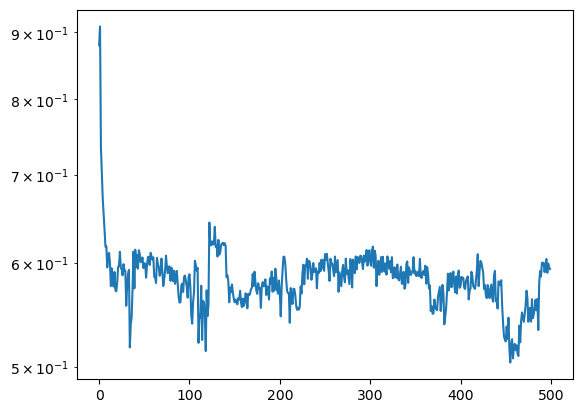

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')
# set maximum y to 

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:25,  2.88s/it]

 20%|██        | 2/10 [00:05<00:23,  2.98s/it]

 30%|███       | 3/10 [00:09<00:21,  3.02s/it]

 40%|████      | 4/10 [00:11<00:17,  2.98s/it]

 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

 60%|██████    | 6/10 [00:17<00:11,  2.93s/it]

 70%|███████   | 7/10 [00:20<00:08,  2.92s/it]

 80%|████████  | 8/10 [00:23<00:05,  2.90s/it]

 90%|█████████ | 9/10 [00:26<00:02,  2.89s/it]

100%|██████████| 10/10 [00:29<00:00,  2.97s/it]

100%|██████████| 10/10 [00:29<00:00,  2.95s/it]

Test Loss: 0.5774


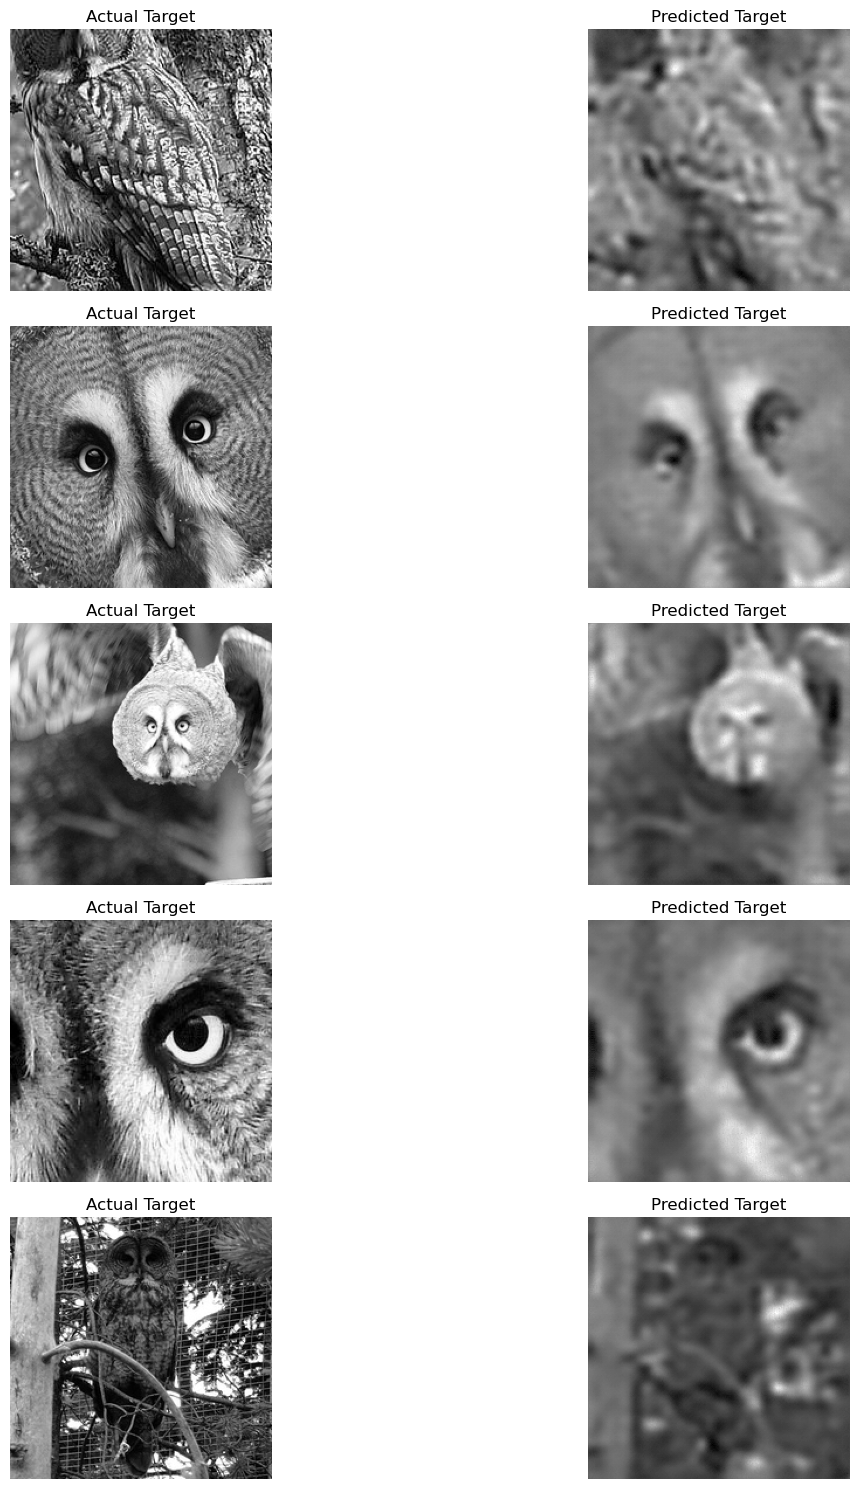

In [8]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Test Loss: {test_loss_partial:.4f}")

def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Target")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [9]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-6.7196) tensor(8.3583)
tensor(0.) tensor(0.9999)


In [10]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
torch.save(model, join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt"))